# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
# Imports
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Criando algumas variáveis
filename_features = "uci-har-dataset/features.txt"
filename_labels = "uci-har-dataset/activity_labels.txt"

filename_subtrain = "uci-har-dataset/train/subject_train.txt"
filename_xtrain = "uci-har-dataset/train/X_train.txt"
filename_ytrain = "uci-har-dataset/train/y_train.txt"

filename_subtest = "uci-har-dataset/test/subject_test.txt"
filename_xtest = "uci-har-dataset/test/X_test.txt"
filename_ytest = "uci-har-dataset/test/y_test.txt"

In [2]:
# Carregando os dados
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze("columns")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label']).squeeze("columns")

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label']).squeeze("columns")


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [3]:
X_train.head()

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [4]:
# PCA para base sem padronização
PCA_X_train = PCA().fit(X_train)

In [5]:
# Autovalores
PCA_X_train.explained_variance_[0:5]

array([34.82363041,  2.73504627,  2.29439284,  1.04377529,  0.943517  ])

In [6]:
%%time

#Padronização dos dados de treino

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

Wall time: 401 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [7]:
# PCA para base com padronização
PCA_X_train_pad = PCA().fit(X_train_pad)

In [8]:
# Autovalores com variáveis padronizadas
PCA_X_train.explained_variance_[0:5]

array([34.82363041,  2.73504627,  2.29439284,  1.04377529,  0.943517  ])

In [9]:
PCA_X_train_pad.explained_variance_[0:5]

array([284.88237655,  36.9176163 ,  15.74411031,  14.0471749 ,
        10.59327893])

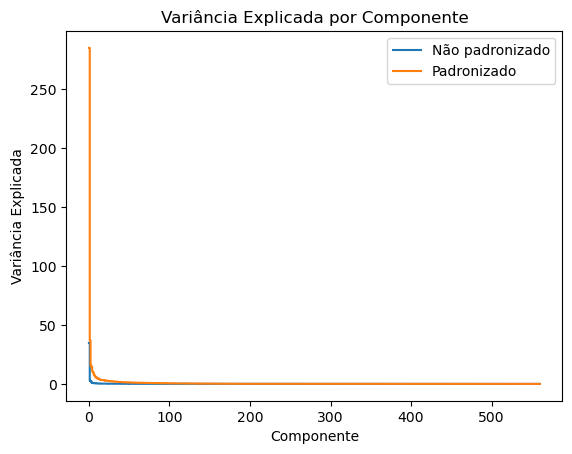

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Explicada")
ax.set_title("Variância Explicada por Componente")
ax.plot(PCA_X_train.explained_variance_, label="Não padronizado",    drawstyle="steps-post")
ax.plot(PCA_X_train_pad.explained_variance_, label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

In [11]:
# Variância nominal acumulada
PCA_X_train.explained_variance_.cumsum()[0:5]

array([34.82363041, 37.55867667, 39.85306951, 40.89684481, 41.84036181])

In [12]:
# Variância nominal acumulada com variáveis padronizadas
PCA_X_train_pad.explained_variance_.cumsum()[0:20]

array([284.88237655, 321.79999285, 337.54410316, 351.59127806,
       362.18455699, 371.85623299, 379.54760733, 386.27443311,
       391.86120496, 397.27534074, 402.10023049, 406.58980662,
       410.87582624, 414.49612151, 418.04346109, 421.40790202,
       424.69957121, 427.92760668, 431.11364375, 434.07177307])

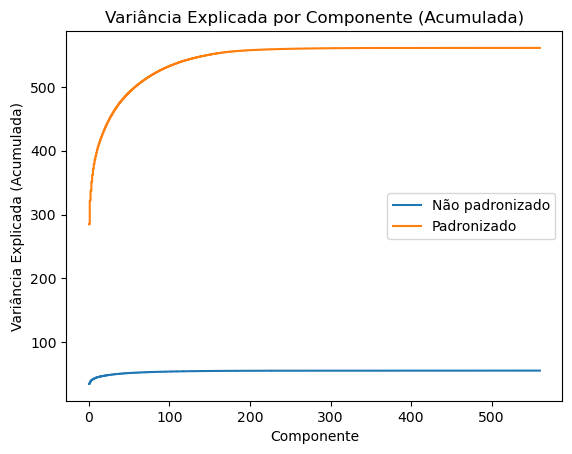

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Explicada (Acumulada)")
ax.set_title("Variância Explicada por Componente (Acumulada)")
ax.plot(PCA_X_train.explained_variance_.cumsum(), label="Não padronizado",    drawstyle="steps-post")
ax.plot(PCA_X_train_pad.explained_variance_.cumsum(), label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

In [14]:
# Variância Percentual
PCA_X_train.explained_variance_ratio_[0:5]

array([0.6255444 , 0.04913023, 0.04121467, 0.01874956, 0.0169486 ])

In [15]:
# Variância Percentual Padronizada
PCA_X_train_pad.explained_variance_ratio_[0:5]

array([0.50781172, 0.0658068 , 0.02806437, 0.02503953, 0.01888285])

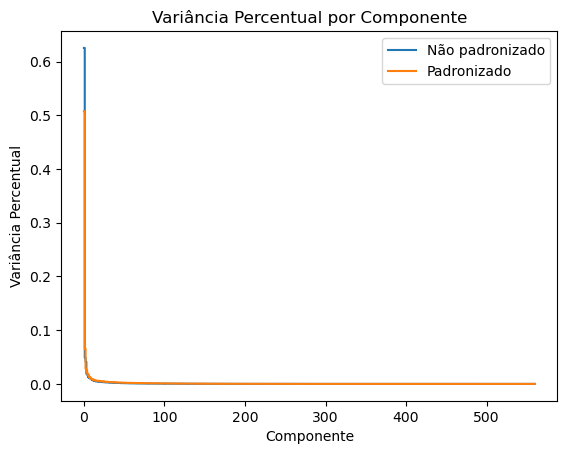

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Percentual")
ax.set_title("Variância Percentual por Componente")
ax.plot(PCA_X_train.explained_variance_ratio_, label="Não padronizado",    drawstyle="steps-post")
ax.plot(PCA_X_train_pad.explained_variance_ratio_, label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

In [17]:
# Variância Percentual Acumulada
PCA_X_train.explained_variance_ratio_.cumsum()[0:10]

array([0.6255444 , 0.67467463, 0.7158893 , 0.73463886, 0.75158746,
       0.76430816, 0.77607501, 0.78676474, 0.79645854, 0.80503872])

In [18]:
# Variância Percentual Acumulada Padronizada
PCA_X_train_pad.explained_variance_ratio_.cumsum()[0:10]

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527,
       0.66284534, 0.67655545, 0.68854623, 0.69850482, 0.70815569])

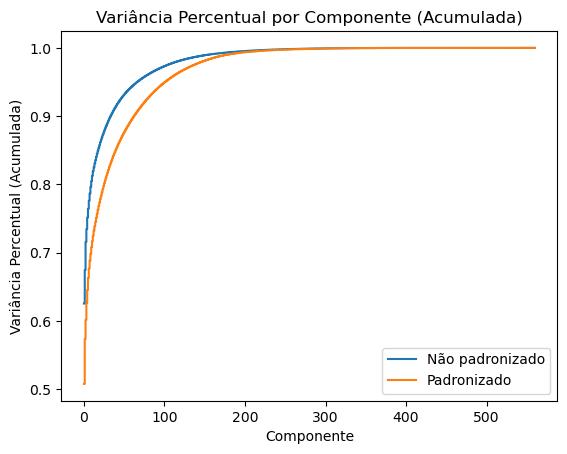

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Percentual (Acumulada)")
ax.set_title("Variância Percentual por Componente (Acumulada)")
ax.plot(PCA_X_train.explained_variance_ratio_.cumsum(), label="Não padronizado",    drawstyle="steps-post")
ax.plot(PCA_X_train_pad.explained_variance_ratio_.cumsum(), label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

In [21]:
ncomp_crit = (PCA_X_train.explained_variance_ratio_.cumsum()<.90).sum()+1

print(f'Número de componentes para dados não padronizados: {ncomp_crit}')

Número de componentes para dados não padronizados: 34


In [22]:
ncomp_crit = (PCA_X_train_pad.explained_variance_ratio_.cumsum()<.90).sum()+1

print(f'Número de componentes para dados padronizados: {ncomp_crit}')

Número de componentes para dados padronizados: 63


- Ao analisar a padronização da base de dados no método de Análise de Componentes Principais (PCA), podemos notar que isso leva a um aumento na quantidade de variância explicada pelos componentes. No entanto, a base de dados não padronizada apresenta melhores resultados em termos de tempo de processamento, requerendo menos componentes para explicar 90% da variância. Isso resulta em uma modelagem mais ágil em comparação com a base de dados padronizada.

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

### Árvore sem padronização

In [24]:
# Calculando as componentes para base de treinamento e teste
pc_treino = PCA_X_train.transform(X_train)
pc_teste  = PCA_X_train.transform(X_test)

# Selecionando as 10 primeiras componentes principais
n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

In [25]:
%%time

# Treinando o modelo
clf = DecisionTreeClassifier(random_state=100, ccp_alpha=0.001)
clf = clf.fit(pc_train, y_train)

# Avaliando a acurácia
acc_tr = clf.score(pc_train, y_train)
acc_te = clf.score(pc_test, y_test)

print(f'A acurácia na base sem padronização de treinos é: {acc_tr}')
print(f'A acurácia na base sem padronização de testes é: {acc_te}')

A acurácia na base sem padronização de treinos é: 0.8926822633297062
A acurácia na base sem padronização de testes é: 0.8238887003732609
Wall time: 197 ms


### Árvore com padronização

In [26]:
# Calculando as componentes para base de treinamento e teste
pc_treino_pad = PCA_X_train_pad.transform(X_train)
pc_teste_pad  = PCA_X_train_pad.transform(X_test)

# Selecionando as 10 primeiras componentes principais
n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train_pad = pd.DataFrame(pc_treino_pad[:,:n], columns = colunas)
pc_test_pad  = pd.DataFrame( pc_teste_pad[:,:n], columns = colunas)

In [27]:
%%time

#Treinando o modelo
clf_pad = DecisionTreeClassifier(random_state=100, ccp_alpha=0.001)

clf_pad = clf_pad.fit(pc_train_pad, y_train)


#Avaliando a acurácia
acc_tr_pad = clf.score(pc_train_pad, y_train)
acc_te_pad = clf.score(pc_test_pad, y_test)

print(f'A acurácia na base com padronização de treinos é: {acc_tr_pad}')
print(f'A acurácia na base com padronização de testes é: {acc_te_pad}')

A acurácia na base com padronização de treinos é: 0.18865614798694233
A acurácia na base com padronização de testes é: 0.1808618934509671
Wall time: 123 ms


#### Conclusão:

No problema em questão, foi observado que a utilização de uma base não padronizada resultou em uma acurácia muito maior do que a base padronizada. No entanto, esse resultado pode ser explicado pelo fato de que apenas 10 componentes principais foram utilizados. Além disso, no item anterior, constatou-se que a base padronizada necessitava de mais componentes para alcançar a mesma porcentagem de variância. É interessante notar que a diferença entre as acurácias das bases de teste e treino na base padronizada foi menor do que a diferença observada na base não padronizada.